In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns

Step 0: load our data

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [ ]:
# Clean our data, deleting useless/non relevant features
data_2 = data.drop(['Unnamed: 0', 'Username', 'JSON file', 'Image files', 'Name',
           'URL', 'TF', 'Bio', 'Category', 'Converted Timestamp', 'Day of Week (String)', 'Detected_Language',
           'is_ad', 'Post ID', 'taken_at_timestamp', 'caption', 'comments_disabled',
           'is_video'], axis = 1)
# Maybe don't delete category and detected languages
# Same with comments disabled and video

Step 1: group and split the data by post_id

In [ ]:
data_2.columns[0:35]

Index(['post_id', 'image_height', 'image_width', 'like_count', 'comment_count',
       'Sponsorship label', 'Followers', 'Followees', 'Posts', 'Year', 'Month',
       'Day', 'Hour', 'Day of Week (Number)', 'Is_English', 'Image_Count',
       'image_0', 'image_1', 'image_2', 'image_3', 'image_4', 'image_5',
       'image_6', 'image_7', 'image_8', 'image_9', 'image_10', 'image_11',
       'image_12', 'image_13', 'image_14', 'image_15', 'image_16', 'image_17',
       'image_18'],
      dtype='object')

Let's split the data!

In [ ]:
# Group data by 'post_id'
grouped = data_2.groupby('post_id')

# Extract the first 'Sponsorship label' for each 'post_id'
sponsorship_labels = grouped['Sponsorship label'].first()

# Make sure the indexes of 'sponsorship_labels' match 'post_ids'
sponsorship_labels = sponsorship_labels.reindex(grouped.size().index)

# Create a list of unique post IDs
post_ids = pd.Series(grouped.size().index)

# Split the data with stratification
train_ids, temp_ids = train_test_split(post_ids, test_size=0.2, random_state=42, stratify=sponsorship_labels)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42, stratify=sponsorship_labels.loc[temp_ids])

# Unnesting the data
train_data = data[data['post_id'].isin(train_ids)]
val_data = data[data['post_id'].isin(val_ids)]
test_data = data[data['post_id'].isin(test_ids)]

In [ ]:
# Group data by 'post_id'
grouped = data_2.groupby('post_id')

# Extract the first 'Sponsorship label' for each 'post_id'
sponsorship_labels = grouped['Sponsorship label'].first()

# Create a list of unique post IDs
post_ids = pd.Series(grouped.size().index)

# Split the data with stratification
train_ids, temp_ids = train_test_split(post_ids, test_size=0.2, random_state=42, stratify=sponsorship_labels)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42, stratify=sponsorship_labels[temp_ids])

Step 2: unnest the grouped data

In [ ]:
# Unnesting the data
train_data = data_2[data_2['post_id'].isin(train_ids)]
val_data = data_2[data_2['post_id'].isin(val_ids)]
test_data = data_2[data_2['post_id'].isin(test_ids)]

In [ ]:
print(f'Train data shape{train_data.shape}')
print(f'Validation data shape{val_data.shape}')
print(f'Test data shape{test_data.shape}')

Train data shape(157038, 2832)
Validation data shape(19584, 2832)
Test data shape(19557, 2832)


Step 2C: box cox to the like count

In [ ]:
from scipy.stats import boxcox

# Apply Box-Cox transformation
train_data.loc[:,'like_count_boxcox'], train_lambda = boxcox(train_data['like_count'] + 1)  # Add 1 to avoid log(0)
val_data.loc[:,'like_count_boxcox'] = boxcox(val_data['like_count'] + 1, lmbda=train_lambda)
test_data.loc[:,'like_count_boxcox'] = boxcox(test_data['like_count'] + 1, lmbda=train_lambda)

<ipython-input-10-6316b9a5b00f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:,'like_count_boxcox'], train_lambda = boxcox(train_data['like_count'] + 1)  # Add 1 to avoid log(0)
<ipython-input-10-6316b9a5b00f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data.loc[:,'like_count_boxcox'] = boxcox(val_data['like_count'] + 1, lmbda=train_lambda)
<ipython-input-10-6316b9a5b00f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

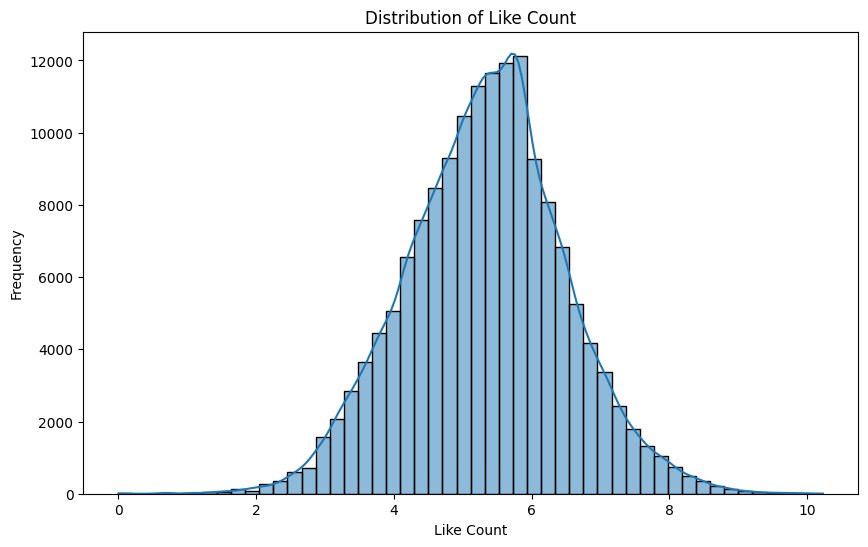

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['like_count_boxcox'], bins=50, kde=True)
plt.title('Distribution of Like Count')
plt.xlabel('Like Count')
plt.ylabel('Frequency')
plt.show()

Step 4: let's do the baseline!

Baseline using Box-Cox likes

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have your original test dataset in `test_data`
# and the like_count is not normalized in this dataset

# Calculate the mean and median of like_count from the training data
mean_like_count = train_data['like_count_boxcox'].mean()
median_like_count = train_data['like_count_boxcox'].median()

# Predict using mean and median for the test set
mean_predictions = np.full(shape=len(test_data), fill_value=mean_like_count)
median_predictions = np.full(shape=len(test_data), fill_value=median_like_count)

# Predict using mean and median for the validation set
mean_predictions_val = np.full(shape=len(val_data), fill_value=mean_like_count)
median_predictions_val = np.full(shape=len(val_data), fill_value=median_like_count)

# Calculate RMSE for the mean and median predictions
rmse_mean = np.sqrt(mean_squared_error(test_data['like_count_boxcox'], mean_predictions))
rmse_median = np.sqrt(mean_squared_error(test_data['like_count_boxcox'], median_predictions))

# Calculate RMSE for the mean and median predictions on validation data
rmse_mean_val = np.sqrt(mean_squared_error(val_data['like_count_boxcox'], mean_predictions_val))
rmse_median_val = np.sqrt(mean_squared_error(val_data['like_count_boxcox'], median_predictions_val))

print(f"Test RMSE for Mean Baseline: {rmse_mean}")
print(f"Test RMSE for Median Baseline: {rmse_median}")

print(f"Validation RMSE for Mean Baseline: {rmse_mean_val}")
print(f"Validation RMSE for Median Baseline: {rmse_median_val}")

Test RMSE for Mean Baseline: 1.1543853233672068
Test RMSE for Median Baseline: 1.1545699664982096
Validation RMSE for Mean Baseline: 1.1476141635520642
Validation RMSE for Median Baseline: 1.1473321603194315


Baseline dropping the top 1% of the data

Baseline dropping the top 5% of the data

Baseline leaving normal variable as is

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have your original test dataset in `test_data`
# and the like_count is not normalized in this dataset

# Calculate the mean and median of like_count from the training data
mean_like_count = train_data['like_count'].mean()
median_like_count = train_data['like_count'].median()

# Predict using mean and median for the test set
mean_predictions = np.full(shape=len(test_data), fill_value=mean_like_count)
median_predictions = np.full(shape=len(test_data), fill_value=median_like_count)

# Predict using mean and median for the validation set
mean_predictions_val = np.full(shape=len(val_data), fill_value=mean_like_count)
median_predictions_val = np.full(shape=len(val_data), fill_value=median_like_count)

# Calculate RMSE for the mean and median predictions
rmse_mean = np.sqrt(mean_squared_error(test_data['like_count'], mean_predictions))
rmse_median = np.sqrt(mean_squared_error(test_data['like_count'], median_predictions))

# Calculate RMSE for the mean and median predictions on validation data
rmse_mean_val = np.sqrt(mean_squared_error(val_data['like_count'], mean_predictions_val))
rmse_median_val = np.sqrt(mean_squared_error(val_data['like_count'], median_predictions_val))

print(f"Test RMSE for Mean Baseline: {rmse_mean}")
print(f"Test RMSE for Median Baseline: {rmse_median}")

print(f"Validation RMSE for Mean Baseline: {rmse_mean_val}")
print(f"Validation RMSE for Median Baseline: {rmse_median_val}")

Test RMSE for Mean Baseline: 72355.06896496158
Test RMSE for Median Baseline: 72487.77443321541
Validation RMSE for Mean Baseline: 47600.18557717632
Validation RMSE for Median Baseline: 47795.40886021795


Baseline normalizing likes

In [ ]:
# Assuming 'train_data' is your training dataset DataFrame and 'like_count' is the column name
train = data_2[data_2['post_id'].isin(train_ids)]
val = data_2[data_2['post_id'].isin(val_ids)]
test = data_2[data_2['post_id'].isin(test_ids)]

std_deviation_likes_train = train['like_count'].std()
std_deviation_likes_val = val['like_count'].std()
std_deviation_likes_test = test['like_count'].std()
print("Train Standard Deviation of 'like_count':", std_deviation_likes_train)
print("Validation Standard Deviation of 'like_count':", std_deviation_likes_val)
print("Test Standard Deviation of 'like_count':", std_deviation_likes_test)

Train Standard Deviation of 'like_count': 49730.81220435244
Validation Standard Deviation of 'like_count': 47599.84604839999
Test Standard Deviation of 'like_count': 72355.453636653
